In [1]:
import numpy as np # very handy numeric package. Mainly for arrays, but includes heaps of handy functions
import matplotlib.pyplot as plt # standard graphics package
from collections import Counter
np.set_printoptions(suppress=True) # suppress scientific notation when printing np arrays. here for troubleshooting

# Hawks Dove RL and Replicator Dynamics

In [2]:
#I start by defining a few helper functions. there may be snazzier ways to do this. numpy is a big package

def multi_argmax(n): #given a numpy array, return an array with all of the arguments = the max value
    return np.where(n==np.max(n))[0]

def recalculate_mean(current_mean,reward,n): #this is equivalent to the form in the book, but I find it easier to understand 
    old_sum = current_mean * (n-1)
    new_sum = old_sum + reward
    return new_sum / n

def recalculate_mean_with_stepsize(current_mean,reward,alpha): #this is the more general form used in the book 
    return current_mean + (alpha * (reward-current_mean))

def dict_multi_argmax(d): # 
    i = list(d.items())  # List of the items in the dictionary, which is a list of pairs
    k = [a for a,b in i] # Give me the first component of the pairs in i
    v = [b for a,b in i] # Give me the second component of the pairs in i
    a = multi_argmax(v) # Give me the indexes of the maximum values in v
    return [k[x] for x in a] # return the actions in k corresponding to the indexes in a

In [3]:
#This is my general bandit, though note that I've built in some details 
#it is a smidge more complicated because I've written it so you can defer updates until after everyone has paired off

class Epsilon_greedy_agent: 
        def __init__(self,belief,epsilon=0.1,action_space=['hawk','dove']):
            self.epsilon = epsilon
            self.estimated_values = {}
            self.times_chosen = {}
            self.update_queue = [] 
            self.belief = belief
            for option in action_space:
                self.estimated_values[option] = 0
                self.times_chosen[option] = 0
            
        def choose_action(self): #not actually updating times chosen until reward step to allow for choice without update
            if np.random.random() >= self.epsilon:  # Basically pic one of the max actions random
                chosen_bandit = np.random.choice(dict_multi_argmax(self.estimated_values))
            else:
                chosen_bandit = np.random.choice(list(self.estimated_values.keys()))
            self.last_chosen = chosen_bandit
            return chosen_bandit
    
        def report_belief(self):
            return self.belief
    
        def add_to_update_queue(self,x):
            self.update_queue.append(x)

        def update_from_queue(self):
            for chosen_bandit,reward in self.update_queue:
                self.times_chosen[chosen_bandit] += 1 #update before recalc otherwise you get div by zero 
                self.estimated_values[chosen_bandit] = recalculate_mean_with_stepsize(  #note line split here, this is  long
                self.estimated_values[chosen_bandit],reward,1/self.times_chosen[chosen_bandit]) #1/n stepsize
            self.clear_update_queue()

        def clear_update_queue(self):
            self.update_queue = [] 

        def get_estimated_values(self):
            return self.estimated_values

# Parameters

In [4]:
agree_payoff = 1
disagree_dict = {'dove': {'dove':0,'hawk':-0.5},'hawk': {'dove': 0.5,'hawk':-2 }} #payoff matrix for disagreement 

In [5]:
iterations = 2500  #iterations in simulation
num_agents = 100   #agents in population 
epsilon = 0.1
proportion = 0.5   #proportion of 'red' agents 
pop_red = int(num_agents*proportion)
pop_blue = num_agents-(int(num_agents*proportion))

In [6]:
#setup the list of agents. This is really crude btw, might be snazzier packages. 

agent_list = [] 


for x in range(int(num_agents*proportion)):   #make the reds 
    agent_list.append(Epsilon_greedy_agent(belief='red',epsilon=epsilon))

for x in range(num_agents-int(num_agents*proportion)):  #and then the blues... 
    agent_list.append(Epsilon_greedy_agent(belief='blue',epsilon=epsilon))

In [7]:
#to start, just assuming  all-to-all connectivity and random choice of one partner per round  
#I'm sure there are nicer ways to do this, especially given the clunky random choice 


rd = {'hawk':np.zeros(iterations),'dove':np.zeros(iterations)} #this track actual actions by round 

hproplist = []   #keep track of proportion of hawk choices
meanreds = []   #mean red payoff per round
meanblues = []    #asnd blues 
for x in range(iterations):
    temppayoffs = {'red':[],'blue':[]}   #track per round payoffs 
    if x % 10 == 0:   #this is so I know how fast it's running 
        print(x // 10,end= " ")
        
    agents = []
    for i in range(num_agents):
        agents.append(i)
        
    for a in agents:   #run through each agent 
        b = a
        
        while a == b:  #randomly choose until you're not pointing at yourself
            b = np.random.choice(agents)
        
        agents.remove(a)
        agents.remove(b)
        a_belief = agent_list[a].report_belief()  #this could all be tighter but this is easy to read 
        b_belief = agent_list[b].report_belief()
        a_action = agent_list[a].choose_action()
        b_action = agent_list[b].choose_action()
        if a_belief == b_belief:
            a_payoff = agree_payoff
            b_payoff = agree_payoff
        else:
            a_payoff = disagree_dict[a_action][b_action]
            b_payoff = disagree_dict[b_action][a_action]
            
        agent_list[a].add_to_update_queue((a_action,a_payoff))  
        agent_list[b].add_to_update_queue((b_action,b_payoff))  #note that the chosen partner also updates, which you could omit 
        temppayoffs[a_belief].append(a_payoff)
        temppayoffs[b_belief].append(b_payoff)
        rd[a_action][x] += 1   #only tracking primary action, but could in theory do both.
    hprop = 0
    for a in range(num_agents):   #after everyone has chosen, then 
        agent_list[a].update_from_queue()    #update with your payoff, it also clears the update queue      
        x = agent_list[a].get_estimated_values() #then go through and see whether hawk is better than dove
        if x['hawk'] > x['dove']:  #and keep track if so. note that this is not tracking *choice* b/c epsilon greedy 
            hprop += 1
            
    #then update running lists 
    hproplist.append(hprop)
    meanreds.append(np.mean(temppayoffs['red']))
    meanblues.append(np.mean(temppayoffs['blue']))



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 

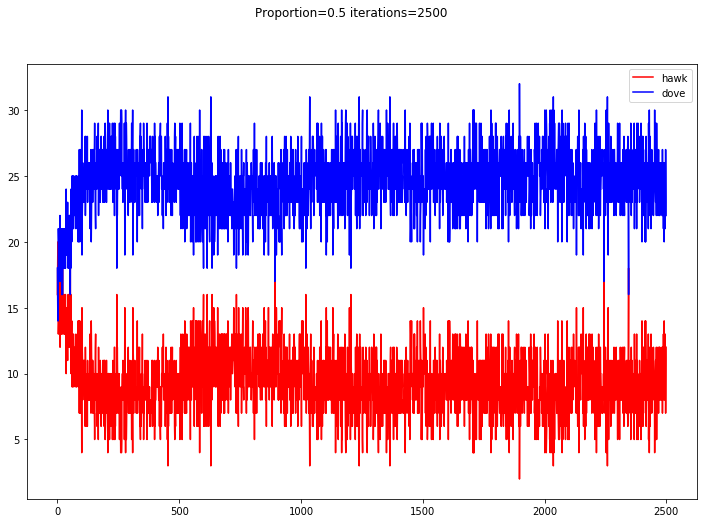

In [8]:
#show actions by round. Note that this is only showing the *primary* action, not the chosen partner action
#this is trying to get a sense of each agents choice, no double counting. 

xs = range(iterations)   

plt.figure(figsize=(12,8))
plt.plot(xs,rd['hawk'],c='r',label='hawk')
plt.plot(xs,rd['dove'],c='b',label='dove')
plt.suptitle("Proportion="+str(proportion)+" iterations="+str(iterations))
plt.legend()
plt.show()

In [9]:
#calculate final proportion of hawk preference by belief 

hcounts = Counter()
hcounts['blue'] = 0
hcounts['red'] = 0
for a in range(num_agents):  
    x= agent_list[a].get_estimated_values()
    if x['hawk']>x['dove']:
        hcounts[agent_list[a].report_belief()] += 1
        
print(num_agents,"agents, with total red = ", proportion*num_agents)
print(hcounts)



100 agents, with total red =  50.0
Counter({'blue': 14, 'red': 13})


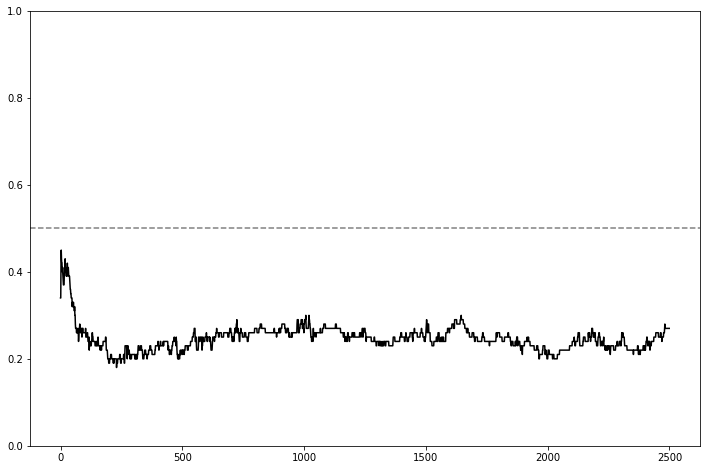

In [10]:
#show hawk proportion over time. 
#note that this doesn't show by belief, but in conjunction w/ above you get a sense of it. 

xs = range(iterations)   

plt.figure(figsize=(12,8))
plt.plot(xs,np.array(hproplist)/num_agents,c='k')
plt.ylim(0,1)
plt.gca().axhline(.50,ls='--',c='k',alpha=0.5)
plt.show()

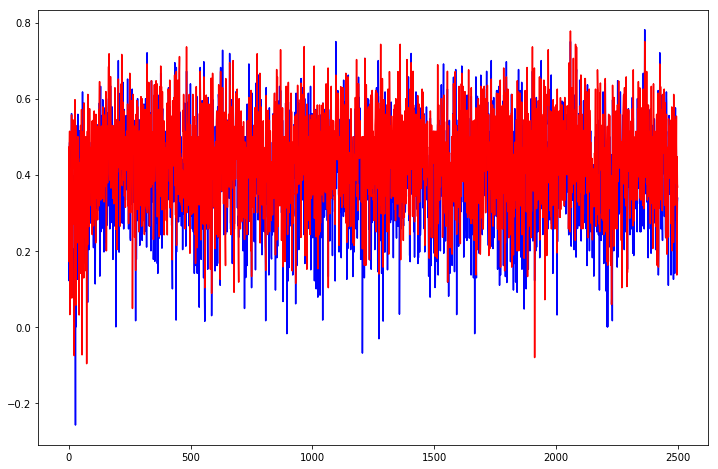

In [11]:
#finally, show mean payoff per round 

xs = range(iterations)   

plt.figure(figsize=(12,8))
plt.plot(xs,meanblues,c='b')
plt.plot(xs,meanreds,c='r')
plt.show()

# Now for the Replicator Dynamics

In replicator dynamics we study which strategies are evolutionary stable. To do that, we need to stipulate, at initiation, which poportion of the reds and blues are hawks and which are doves. For simplicity, we start with same proportion of hawks for the two types.

## All populations vary

Here we have the case in which all populations vary. Next we will study the case in which the red and blue populations are fixed, and what varies is what strategies they play.

In [12]:
proportion_hawk = 0.5 # proportion of hawkes at initiation for both types

In [13]:
# We use lists to keep track of populations cause they change at each iteration
prop_red_hawk = [(pop_red*proportion_hawk)/num_agents]
prop_red_dove = [(pop_red*(1-proportion_hawk))/num_agents]
prop_blue_hawk = [(pop_blue*proportion_hawk)/num_agents]
prop_blue_dove = [(pop_blue*(1-proportion_hawk))/num_agents]

# Time step
dt = 0.1

# fitness for each population. Again we use lists because these change
F_red_hawk = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_red_dove = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['dove']['hawk'])+(prop_blue_dove[0]*disagree_dict['dove']['dove']))*dt]
F_blue_hawk = [((agree_payoff * (prop_blue_hawk[0] + prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_red_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_blue_dove = [((agree_payoff * (prop_blue_hawk[0]+prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['dove']['hawk'])+(prop_red_dove[0]*disagree_dict['dove']['dove']))*dt]

# Average fitness
F_average = [((F_red_hawk[0]*prop_red_hawk[0])+(F_red_dove[0]*prop_red_dove[0])+(F_blue_hawk[0]*prop_blue_hawk[0])+(F_blue_dove[0]*prop_blue_dove[0]))*dt]

In [14]:
print(prop_blue_hawk)
print(F_red_dove)
print(prop_red_hawk[0]+prop_red_dove[0]+prop_blue_hawk[0]+prop_blue_dove[0])

[0.25]
[0.037500000000000006]
1.0


In [15]:
# Simulations

for t in range(35):
    # fitnesses for populations at t
    f_red_hawk = (agree_payoff * (prop_red_hawk[t] + prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[t]*disagree_dict['hawk']['dove'])
    f_red_dove = (agree_payoff * (prop_red_hawk[t]+prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['dove']['hawk'])+(prop_blue_dove[t]*disagree_dict['dove']['dove'])
    f_blue_hawk = (agree_payoff * (prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_red_dove[t]*disagree_dict['hawk']['dove'])
    f_blue_dove = (agree_payoff * (prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['dove']['hawk'])+(prop_red_dove[t]*disagree_dict['dove']['dove'])

    # Average fitness at t
    f_average = (f_red_hawk*prop_red_hawk[t])+(f_red_dove*prop_red_dove[t])+(f_blue_hawk*prop_blue_hawk[t])+(f_blue_dove*prop_blue_dove[t])
    
    # update the fitness lists
    F_red_hawk.append(f_red_hawk*dt)
    F_red_dove.append(f_red_dove*dt)
    F_blue_hawk.append(f_blue_hawk*dt)
    F_blue_dove.append(f_blue_dove*dt)
    F_average.append(f_average*dt)
    
    # differential equations for populations
    # The idea here is that each population is updated according to how successful they
    # were in the previous iteration: d_pop/dt = pop*(f_pop - f_average)
    prop_red_hawk.append(prop_red_hawk[t]+(prop_red_hawk[t]*(f_red_hawk-f_average))*dt)
    prop_red_dove.append(prop_red_dove[t]+(prop_red_dove[t]*(f_red_dove-f_average))*dt)
    prop_blue_hawk.append(prop_blue_hawk[t]+(prop_blue_hawk[t]*(f_blue_hawk-f_average))*dt)
    prop_blue_dove.append(prop_blue_dove[t]+(prop_blue_dove[t]*(f_blue_dove-f_average))*dt)
    
    

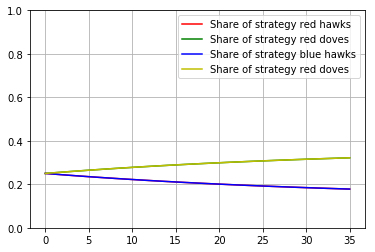

In [16]:
# Plotting

plt.plot(prop_red_hawk, 'r', label ='Share of strategy red hawks')
plt.plot(prop_red_dove, 'g', label ='Share of strategy red doves')
plt.plot(prop_blue_hawk, 'b', label ='Share of strategy blue hawks')
plt.plot(prop_blue_dove, 'y', label ='Share of strategy red doves')
plt.grid()
plt.ylim(0, 1)
plt.legend(loc='best')

# Only strategy populations vary, but not type

In [17]:
# We use lists to keep track of populations cause they change at each iteration
prop_red_hawk = [(pop_red*proportion_hawk)/num_agents]
prop_red_dove = [(pop_red*(1-proportion_hawk))/num_agents]
prop_red = pop_red/num_agents
prop_blue_hawk = [(pop_blue*proportion_hawk)/num_agents]
prop_blue_dove = [(pop_blue*(1-proportion_hawk))/num_agents]
prop_blue = pop_blue/num_agents

# Time step
dt = 0.1

# fitness for each population. Again we use lists because these change
F_red_hawk = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_red_dove = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['dove']['hawk'])+(prop_blue_dove[0]*disagree_dict['dove']['dove']))*dt]
F_blue_hawk = [((agree_payoff * (prop_blue_hawk[0] + prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_red_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_blue_dove = [((agree_payoff * (prop_blue_hawk[0]+prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['dove']['hawk'])+(prop_red_dove[0]*disagree_dict['dove']['dove']))*dt]

# Average fitness
F_average = [((F_red_hawk[0]*prop_red_hawk[0])+(F_red_dove[0]*prop_red_dove[0])+(F_blue_hawk[0]*prop_blue_hawk[0])+(F_blue_dove[0]*prop_blue_dove[0]))*dt]

# The catch now is that the population dynamics is defined for each group independently
# So we need to compute the average fitness for each group
F_average_red = [(((F_red_hawk[0]*prop_red_hawk[0])+(F_red_dove[0]*prop_red_dove[0]))*(1/prop_red))*dt]
F_average_blue = [(((F_blue_hawk[0]*prop_blue_hawk[0])+(F_blue_dove[0]*prop_blue_dove[0]))*(1/prop_blue))*dt]



In [18]:
print(prop_blue_hawk)
print(F_red_dove)
print(prop_red_hawk[0]+prop_red_dove[0]+prop_blue_hawk[0]+prop_blue_dove[0])

[0.25]
[0.037500000000000006]
1.0


In [19]:
# Simulations

for t in range(100):
    # fitnesses for populations at t
    f_red_hawk = (agree_payoff*(prop_red_hawk[t]+prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[t]*disagree_dict['hawk']['dove'])
    f_red_dove = (agree_payoff*(prop_red_hawk[t]+prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['dove']['hawk'])+(prop_blue_dove[t]*disagree_dict['dove']['dove'])
    f_blue_hawk = (agree_payoff*(prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_red_dove[t]*disagree_dict['hawk']['dove'])
    f_blue_dove = (agree_payoff*(prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['dove']['hawk'])+(prop_red_dove[t]*disagree_dict['dove']['dove'])

    # Average fitness at t
    f_average = (f_red_hawk*prop_red_hawk[t])+(f_red_dove*prop_red_dove[t])+(f_blue_hawk*prop_blue_hawk[t])+(f_blue_dove*prop_blue_dove[t])
    
    # Since the evolutionary dynamics is within group, we need to compare, for each group
    # which strategy is more stable
    # We have to normalize by the proportion of reds and blues
    f_average_red = ((f_red_hawk*prop_red_hawk[t])+(f_red_dove*prop_red_dove[t]))*(1/prop_red)
    f_average_blue = ((f_blue_hawk*prop_blue_hawk[t])+(f_blue_dove*prop_blue_dove[t]))*(1/prop_blue)
    
    # update the fitness lists
    F_red_hawk.append(f_red_hawk*dt)
    F_red_dove.append(f_red_dove*dt)
    F_blue_hawk.append(f_blue_hawk*dt)
    F_blue_dove.append(f_blue_dove*dt)
    F_average.append(f_average*dt)
    F_average_red.append(f_average_red)
    F_average_blue.append(f_average_blue)
    
    # differential equations for populations
    # The idea here is that each population is updated according to how successful they
    # were in the previous iteration: d_pop_color)_strategy/dt = pop_color_strategy*(f_pop_c_s - f_average_c)
    prop_red_hawk.append(prop_red_hawk[t]+(prop_red_hawk[t]*(f_red_hawk-f_average_red))*dt)
    prop_red_dove.append(prop_red_dove[t]+(prop_red_dove[t]*(f_red_dove-f_average_red))*dt)
    prop_blue_hawk.append(prop_blue_hawk[t]+(prop_blue_hawk[t]*(f_blue_hawk-f_average_blue))*dt)
    prop_blue_dove.append(prop_blue_dove[t]+(prop_blue_dove[t]*(f_blue_dove-f_average_blue))*dt)
    
    

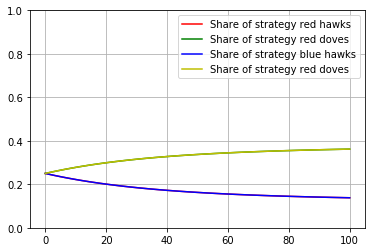

In [21]:
# Plotting is the same

plt.plot(prop_red_hawk, 'r', label ='Share of strategy red hawks')
plt.plot(prop_red_dove, 'g', label ='Share of strategy red doves')
plt.plot(prop_blue_hawk, 'b', label ='Share of strategy blue hawks')
plt.plot(prop_blue_dove, 'y', label ='Share of strategy red doves')
plt.grid()
plt.ylim(0, 1)
plt.legend(loc='best')